# Simulation of a "zagi-like" flying wing UAV

Import modules and configure the notebook.

In [1]:
# This module is part of the python standard library
import time

# These modules are part of other existing libraries
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
import asyncio

# This is my own script (it is an interface to the pybullet simulator)
import ae353_zagi

In [2]:
import numpy as np
import sympy as sym
from scipy import linalg
import matplotlib.pyplot as plt
from IPython.display import display, Latex, Markdown
# from control import lqr, ctrb
from scipy.optimize import minimize
from scipy.linalg import solve_continuous_are

#
# VARIABLES
#

# Time
t = sym.Symbol('t', real=True)

# Components of position (meters)
p_x, p_y, p_z = sym.symbols('p_x, p_y, p_z', real=True)

# Yaw, pitch, and roll angles (radians)
psi, theta, phi = sym.symbols('psi, theta, phi', real=True)

# Components of linear velocity in the body frame (meters / second)
v_x, v_y, v_z = sym.symbols('v_x, v_y, v_z', real=True)

# Components of angular velocity in the body frame (radians / second)
w_x, w_y, w_z = sym.symbols('w_x, w_y, w_z', real=True)

# Elevon angles
delta_r, delta_l = sym.symbols('delta_r, delta_l', real=True)

#
# PARAMETERS
#

# Aerodynamic parameters
rho, S, c, b = sym.symbols('rho, S, c, b', real=True)
C_L_0, C_L_alpha, C_L_q, C_L_delta_e = sym.symbols('C_L_0, C_L_alpha, C_L_q, C_L_delta_e', real=True)
C_D_0, C_D_alpha, C_D_q, C_D_delta_e = sym.symbols('C_D_0, C_D_alpha, C_D_q, C_D_delta_e', real=True)
C_m_0, C_m_alpha, C_m_q, C_m_delta_e = sym.symbols('C_m_0, C_m_alpha, C_m_q, C_m_delta_e', real=True)
C_Y_0, C_Y_beta, C_Y_p, C_Y_r, C_Y_delta_a = sym.symbols('C_Y_0, C_Y_beta, C_Y_p, C_Y_r, C_Y_delta_a', real=True)
C_l_0, C_l_beta, C_l_p, C_l_r, C_l_delta_a = sym.symbols('C_l_0, C_l_beta, C_l_p, C_l_r, C_l_delta_a', real=True)
C_n_0, C_n_beta, C_n_p, C_n_r, C_n_delta_a = sym.symbols('C_n_0, C_n_beta, C_n_p, C_n_r, C_n_delta_a', real=True)
e, alpha_0, C_D_p, M = sym.symbols('e, alpha_0, C_D_p, M', real=True)
k, k_e = sym.symbols('k, k_e', real=True)

# Mass and inertia parameters
J_x, J_y, J_z, J_xz = sym.symbols('J_x, J_y, J_z, J_xz', real=True)
m, g = sym.symbols('m, g', real=True)

params = {
    g: 9.81,               # Gravity (m/s²)
    m: 1.56,               # Mass of the UAV (kg)
    J_x: 0.1147,           # Moment of inertia about x-axis (kg·m²)
    J_y: 0.0576,           # Moment of inertia about y-axis (kg·m²)
    J_z: 0.1712,           # Moment of inertia about z-axis (kg·m²)
    J_xz: 0.0015,          # Product of inertia (kg·m²)

    S: 0.4696,             # Wing area (m²)
    b: 1.4224,             # Wingspan (m)
    c: 0.3302,             # Mean aerodynamic chord (m)

    rho: 1.2682,           # Air density (kg/m³)

    # Lift Coefficients
    C_L_0: 0.2,            # Lift coefficient at zero AoA
    C_L_alpha: 4.8,        # Lift curve slope (1/rad)
    C_L_q: 2.2,            # Pitch rate effect on lift (1/rad)

    # Drag Coefficients
    C_D_0: 0.02,           # Zero-lift drag coefficient
    C_D_alpha: 0.30,       # Drag change per AoA (1/rad)
    C_D_q: 0.0,            # Pitch rate effect on drag (1/rad)
    C_D_p: 0.03,           # Parasitic drag coefficient

    # Pitching Moment Coefficients
    C_m_0: -0.02,          # Pitching moment at zero AoA
    C_m_alpha: -0.6,       # Pitching moment change per AoA (1/rad)
    C_m_q: -1.8,           # Pitch rate effect on moment (1/rad)
    C_m_delta_e: -0.35,    # Effect of elevator deflection on pitching moment (1/rad)

    # Side Force Coefficients
    C_Y_0: 0.0,            # Side force at zero sideslip
    C_Y_beta: -0.08,       # Side force per sideslip angle (1/rad)
    C_Y_p: 0.0,            # Side force due to roll rate
    C_Y_r: 0.0,            # Side force due to yaw rate
    C_Y_delta_a: 0.0,      # Side force due to aileron deflection

    # Roll Moment Coefficients
    C_l_0: 0.0,            # Roll moment at zero sideslip
    C_l_beta: -0.10,       # Roll moment due to sideslip (1/rad)
    C_l_p: -0.45,          # Roll damping derivative (1/rad)
    C_l_r: 0.03,           # Roll moment due to yaw rate (1/rad)
    C_l_delta_a: 0.18,     # Aileron effect on roll (1/rad)

    # Yaw Moment Coefficients
    C_n_0: 0.0,            # Yaw moment at zero sideslip
    C_n_beta: 0.008,       # Yaw moment due to sideslip (1/rad)
    C_n_p: -0.022,         # Yaw moment due to roll rate (1/rad)
    C_n_r: -0.009,         # Yaw damping derivative (1/rad)
    C_n_delta_a: -0.004,   # Aileron effect on yaw (1/rad)

    # Control Derivatives
    C_L_delta_e: 0.30,     # Effect of elevator deflection on lift (1/rad)
    C_D_delta_e: 0.32,     # Effect of elevator deflection on drag (1/rad)

    # Efficiency Factors
    e: 0.85,               # Oswald efficiency factor
    alpha_0: 0.45,         # Zero-lift angle of attack (rad)

    # Additional Drag & Lift Coefficients
    M: 50.0,               # Sigmoid blending function parameter
    k_e: 0.01,             # Drag due to elevator deflection (empirical coefficient)
    k: 0.048               # Induced drag factor
}

# Get airspeed, angle of attack, and angle of sideslip
V_a = sym.sqrt(v_x**2 + v_y**2 + v_z**2)
alpha = sym.atan(v_z / v_x)
beta = sym.asin(v_y / V_a)

# Convert from right and left elevon deflections to equivalent elevator and aileron deflections
delta_e = (delta_r + delta_l) / 2
delta_a = (-delta_r + delta_l) / 2

# Longitudinal aerodynamics
C_L = C_L_0 + C_L_alpha * alpha
F_lift = rho * V_a**2 * S * (C_L + C_L_q * (c / (2 * V_a)) * w_y + C_L_delta_e * delta_e) / 2
F_drag = rho * V_a**2 * S * ((C_D_0 + k * C_L**2) + C_D_q * (c / (2 * V_a)) * w_y + k_e * (C_L_delta_e * delta_e)**2) / 2
f_x, f_z = sym.Matrix([[sym.cos(alpha), -sym.sin(alpha)], [sym.sin(alpha), sym.cos(alpha)]]) @ sym.Matrix([[-F_drag], [-F_lift]])
tau_y = rho * V_a**2 * S * c * (C_m_0 + C_m_alpha * alpha + C_m_q * (c / (2 * V_a)) * w_y + C_m_delta_e * delta_e) / 2

# Lateral aerodynamics
f_y =   rho * V_a**2 * S *     (C_Y_0 + C_Y_beta * beta + C_Y_p * (b / (2 * V_a)) * w_x + C_Y_r * (b / (2 * V_a)) * w_z + C_Y_delta_a * delta_a) / 2
tau_x = rho * V_a**2 * S * b * (C_l_0 + C_l_beta * beta + C_l_p * (b / (2 * V_a)) * w_x + C_l_r * (b / (2 * V_a)) * w_z + C_l_delta_a * delta_a) / 2
tau_z = rho * V_a**2 * S * b * (C_n_0 + C_n_beta * beta + C_n_p * (b / (2 * V_a)) * w_x + C_n_r * (b / (2 * V_a)) * w_z + C_n_delta_a * delta_a) / 2

v_inB_ofWB = sym.Matrix([v_x, v_y, v_z])
w_inB_ofWB = sym.Matrix([w_x, w_y, w_z])

J_inB = sym.Matrix([[  J_x,    0, -J_xz],
                    [    0,  J_y,     0],
                    [-J_xz,    0,   J_z]])

Rz = sym.Matrix([[sym.cos(psi), -sym.sin(psi), 0],
                 [sym.sin(psi), sym.cos(psi), 0],
                 [0, 0, 1]])

Ry = sym.Matrix([[sym.cos(theta), 0, sym.sin(theta)],
                 [0, 1, 0],
                 [-sym.sin(theta), 0, sym.cos(theta)]])

Rx = sym.Matrix([[1, 0, 0],
                 [0, sym.cos(phi), -sym.sin(phi)],
                 [0, sym.sin(phi), sym.cos(phi)]])

R_inW_ofB = Rz @ Ry @ Rx

# First, compute the inverse of N
Ninv = sym.Matrix.hstack((Ry * Rx).T * sym.Matrix([0, 0, 1]),
                              (Rx).T * sym.Matrix([0, 1, 0]),
                                       sym.Matrix([1, 0, 0]))

# Then, take the inverse of this result to compute N
N = sym.simplify(Ninv.inv())

# Total force
f_inB = R_inW_ofB.T * sym.Matrix([0, 0, m * g]) + sym.Matrix([f_x, f_y, f_z])

# Total torque
tau_inB = sym.Matrix([tau_x, tau_y, tau_z])

f_sym = sym.Matrix.vstack(
    R_inW_ofB * v_inB_ofWB,
    N * w_inB_ofWB,
    (1 / m) * (f_inB - w_inB_ofWB.cross(m * v_inB_ofWB)),
    J_inB.inv() * (tau_inB - w_inB_ofWB.cross(J_inB * w_inB_ofWB)),
)

f = f_sym.subs(params)



In [ ]:
remove = [0, 2]  
f_mod = sym.Matrix([f[i] for i in range(f.shape[0]) if i not in remove])
f_mod = sym.nsimplify(f_mod, rational=True)

f_num = sym.lambdify(
    [p_y, psi, theta, phi, v_x, v_y, v_z, w_x, w_y, w_z, delta_r, delta_l], 
    f_mod
)

f_num_for_minimize = lambda x: np.linalg.norm(f_num(*x).flatten())**2

x0 = [0, 0, 0, 0, 5, 0, -0.5, 0, 0, 0, 0, 0]

sol = minimize(f_num_for_minimize, x0, tol=1e-4)

(p_y_e, phi_e, theta_e, psi_e, v_x_e, v_y_e, v_z_e, 
 w_x_e, w_y_e, w_z_e, delta_r_e, delta_l_e) = sol.x

A = sym.lambdify(
    (p_y, psi, theta, phi, v_x, v_y, v_z, w_x, w_y, w_z, delta_r, delta_l), 
    f_mod.jacobian([p_y, psi, theta, phi, v_x, v_y, v_z, w_x, w_y, w_z]), 
    'numpy'
)

B = sym.lambdify(
    (p_y, psi, theta, phi, v_x, v_y, v_z, w_x, w_y, w_z, delta_r, delta_l), 
    f_mod.jacobian([delta_r, delta_l]), 
    'numpy'
)

A_num = A(p_y_e, psi_e, theta_e, phi_e, v_x_e, v_y_e, v_z_e, 
          w_x_e, w_y_e, w_z_e, delta_r_e, delta_l_e)

B_num = B(p_y_e, psi_e, theta_e, phi_e, v_x_e, v_y_e, v_z_e, 
          w_x_e, w_y_e, w_z_e, delta_r_e, delta_l_e)

A_num = np.array(A_num).astype(np.float64)
B_num = np.array(B_num).astype(np.float64)

def lqr(A, B, Q, R):
    P = solve_continuous_are(A, B, Q, R) 
    K = np.linalg.inv(R) @ B.T @ P
    return K, P

Q = np.diag([1, 1, 1, 1, 1, 1, 1, 4, 4, 4])
Q = np.array(Q, dtype=np.float64)

R = np.diag([1, 1])
R = np.array(R, dtype=np.float64)

K, P = lqr(A_num, B_num, Q, R)

K = np.array(K, dtype=np.float64)

Create an instance of the `Simulator` class, which is an interface to the [pybullet](http://pybullet.org) simulation engine.

In [4]:
simulator = ae353_zagi.Simulator(
    display=True,       # Whether or not to show the simulation window. The simulation will
                        # run much faster if you do not show this window, so set display to
                        # False if you want to run many simulations to collect results.
)

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7000/static/


Choose a camera view from the following options:
* `camera_launchview()`
* `camera_landview()`
* `camera_catview()`

The "cat view" follows the aircraft in flight. You may see the simulation window flicker when using this option. We suggest that you only use it when capturing video (you won't see any flickering in the video that is saved).

In [5]:
simulator.camera_catview()

Define a controller that maps sensor measurements to actuator commands. By default, it chooses zero elevon deflection angles. Modify the `run` function to make the controller behave differently. This function will be called 100 times per second (i.e., at 100 Hz) by the simulator.

In [6]:
class Controller:
    def __init__(self):
        self.K = K
        print(self.K)
        self.trim = np.array([p_y_e, psi_e, theta_e, phi_e, v_x_e, v_y_e, v_z_e, w_x_e, w_y_e, w_z_e]).T
        self.u_e = np.array([[delta_r_e], [delta_l_e]])
    
    def reset(self):
        pass
    
    def run(
            self,
            t,                      # current time
            p_x, p_y, p_z,          # components of position (+z is down!)
            psi, theta, phi,        # yaw, pitch, and roll angles
            v_x, v_y, v_z,          # components of linear velocity in the body frame
            w_x, w_y, w_z,          # components of angular velocity in the body frame
        ):
        x = np.array([p_y, psi, theta, phi, v_x, v_y, v_z, w_x, w_y, w_z]).T
        x_dev = x - self.trim
        u =  - self.K @ x_dev
        
        delta_r = u[0]                # right elevon deflection angle (positive is down)
        delta_l = u[1] 
        
        return delta_r, delta_l

Create an instance of the controller.

In [7]:
controller = Controller()

[[-0.70710712 -9.22319625 -3.74345038 -6.01611099  0.27376632 -1.42823413
   0.33620311 -1.39859    -1.36956585 -7.19907645]
 [ 0.70710645  9.22318985 -3.74364424  6.01604126  0.2737672   1.42823402
   0.33620106  1.39858893 -1.36956518  7.19896794]]


Reset the simulator with given initial conditions (example).

In [8]:
simulator.reset(
    initial_conditions = {
        'p_x':   0.,
        'p_y':   0.,
        'p_z':   0.,
        'psi':   0.,
        'theta': 0.,
        'phi':   0.,
        'v_x':   5.,
        'v_y':   0.,
        'v_z':   0.,
        'w_x':   0.,
        'w_y':   0.,
        'w_z':   0.,
    }
)

Reset the simulator with random initial conditions (example).

In [9]:
simulator.reset()

Reset the controller.

In [10]:
controller.reset()

Run the simulator.

In [11]:
data = simulator.run(
    controller,           # <-- required (an instance of your Controller class)
    maximum_time=30.,      # <-- optional (how long you want to run the simulation in seconds)
    data_filename=None,   # <-- optional (save data to this file, e.g., 'my_data.json')
    video_filename=None,  # <-- optional (save video to this file, e.g., 'my_video.mov')
)

Check if the aircraft has landed.

In [12]:
has_landed = simulator.has_landed()
if has_landed:
    print('The aircraft landed.')
else:
    print('The aircraft did not land.')

The aircraft landed.


Get, show, and save a snapshot of the simulation after the last time step.

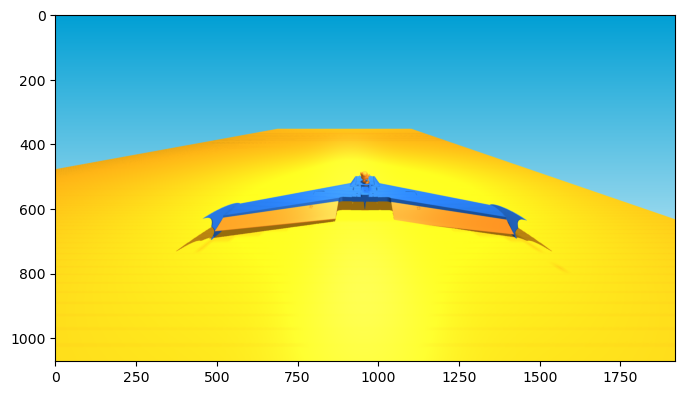

In [13]:
# Get snapshot as height x width x 4 numpy array of RGBA values
rgba = simulator.snapshot()

# Display snapshot
plt.figure(figsize=(8, 8))
plt.imshow(rgba)

# Save snapshot
plt.imsave('my_snapshot.png', rgba)

Plot the results.

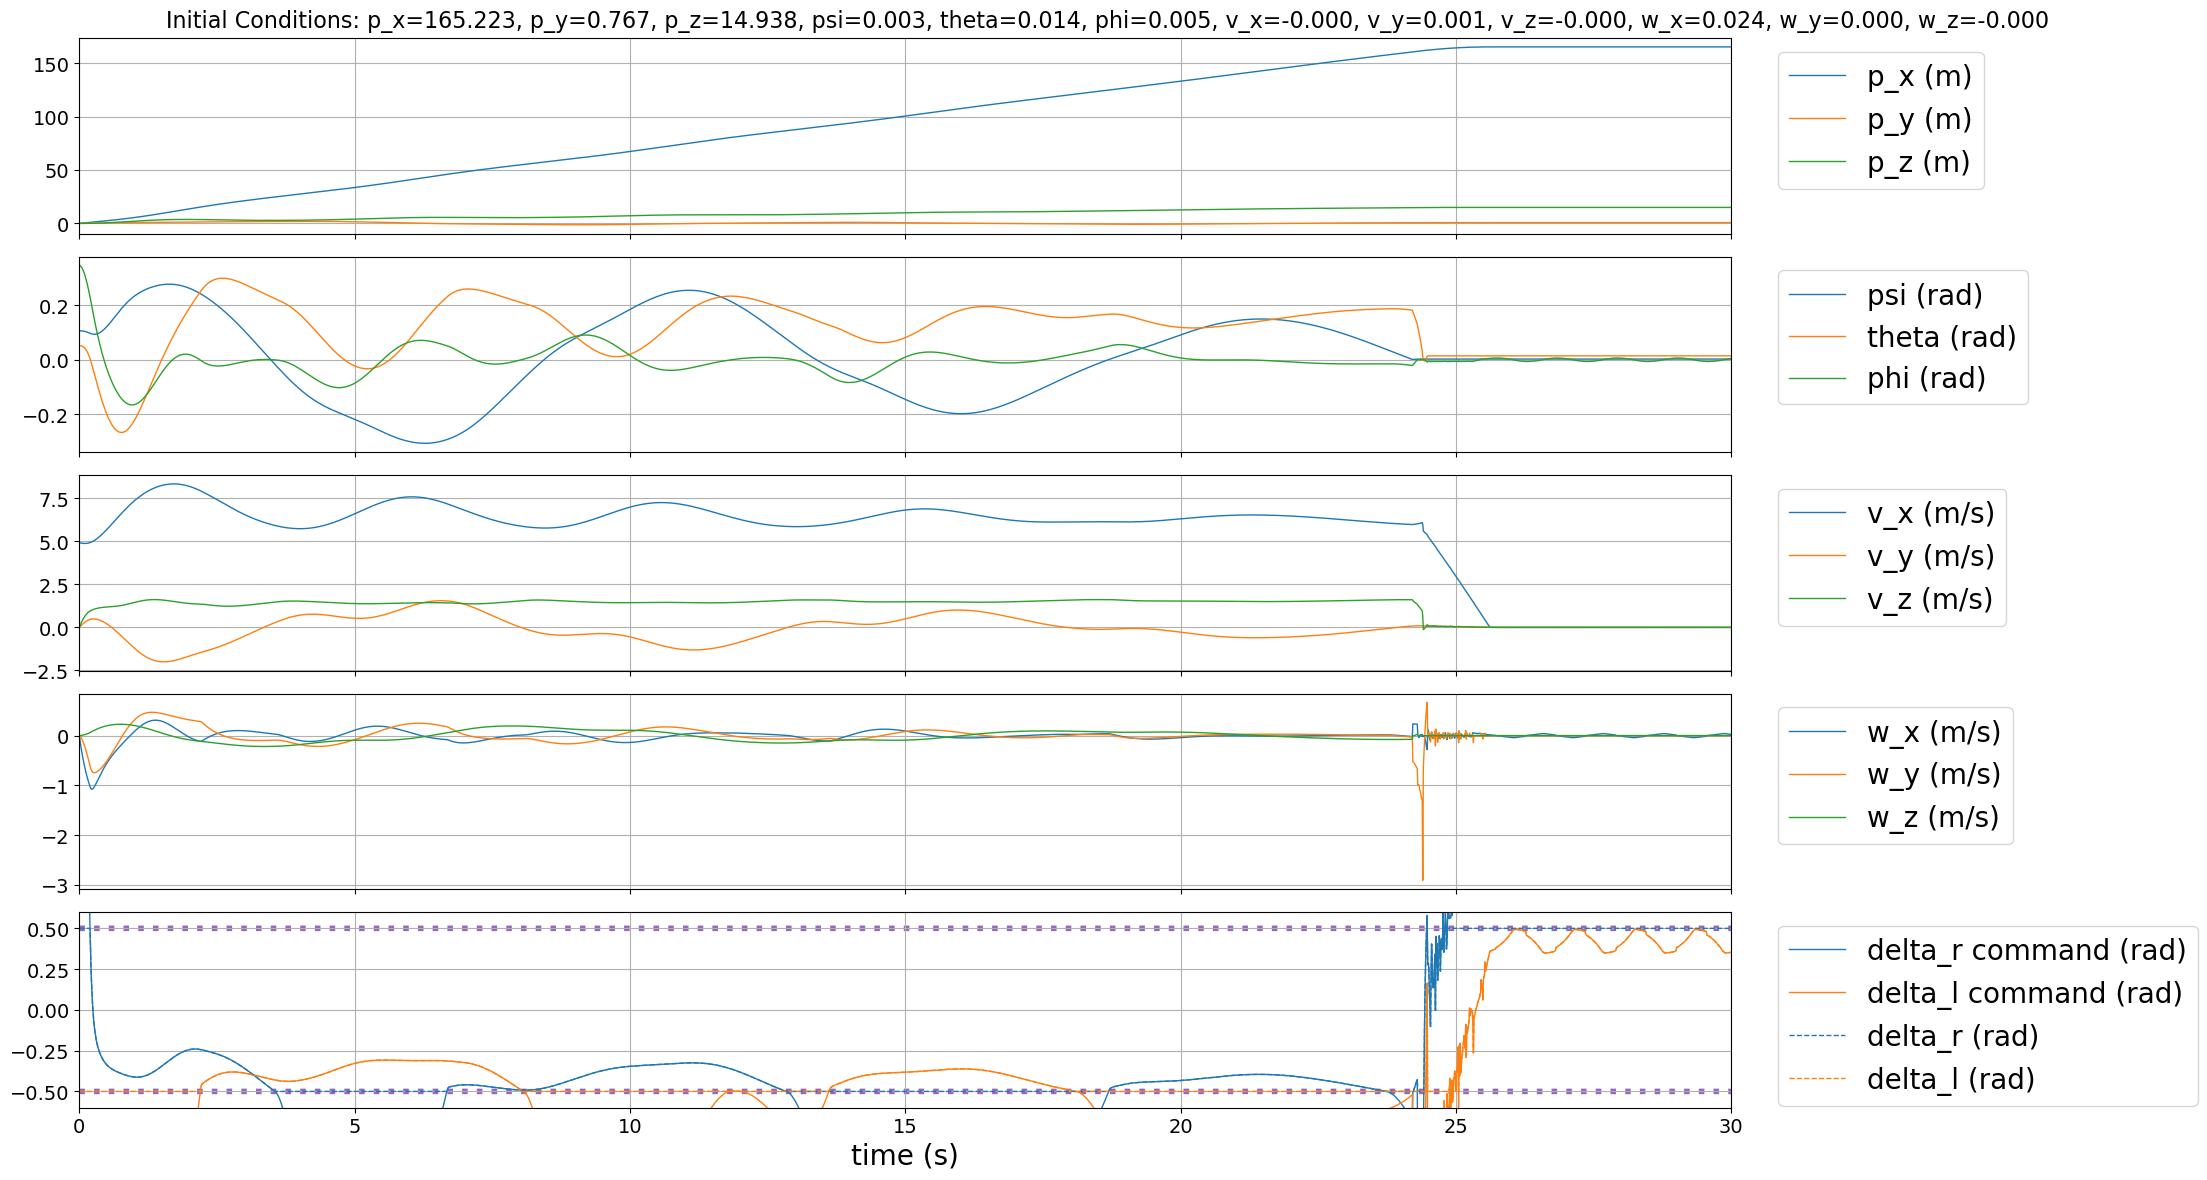

In [14]:
import matplotlib.pyplot as plt
import numpy as np

# Extract initial conditions from flight simulator
x_e = [
    simulator.bullet_client.getBasePositionAndOrientation(simulator.robot_id)[0][0],  # p_x
    simulator.bullet_client.getBasePositionAndOrientation(simulator.robot_id)[0][1],  # p_y
    simulator.bullet_client.getBasePositionAndOrientation(simulator.robot_id)[0][2],  # p_z
    simulator.bullet_client.getEulerFromQuaternion(simulator.bullet_client.getBasePositionAndOrientation(simulator.robot_id)[1])[2],  # psi
    simulator.bullet_client.getEulerFromQuaternion(simulator.bullet_client.getBasePositionAndOrientation(simulator.robot_id)[1])[1],  # theta
    simulator.bullet_client.getEulerFromQuaternion(simulator.bullet_client.getBasePositionAndOrientation(simulator.robot_id)[1])[0],  # phi
    simulator.bullet_client.getBaseVelocity(simulator.robot_id)[0][0],  # v_x
    simulator.bullet_client.getBaseVelocity(simulator.robot_id)[0][1],  # v_y
    simulator.bullet_client.getBaseVelocity(simulator.robot_id)[0][2],  # v_z
    simulator.bullet_client.getBaseVelocity(simulator.robot_id)[1][0],  # w_x
    simulator.bullet_client.getBaseVelocity(simulator.robot_id)[1][1],  # w_y
    simulator.bullet_client.getBaseVelocity(simulator.robot_id)[1][2],  # w_z
]
x_e_str = ", ".join([f"p_x={x_e[0]:.3f}, p_y={x_e[1]:.3f}, p_z={x_e[2]:.3f}, psi={x_e[3]:.3f}, theta={x_e[4]:.3f}, phi={x_e[5]:.3f}, v_x={x_e[6]:.3f}, v_y={x_e[7]:.3f}, v_z={x_e[8]:.3f}, w_x={x_e[9]:.3f}, w_y={x_e[10]:.3f}, w_z={x_e[11]:.3f}"])


# Create a figure with five subplots, all of which share the same x-axis
fig, (
    ax_pos,
    ax_ori,
    ax_linvel,
    ax_angvel,
    ax_delta,
) = plt.subplots(5, 1, figsize=(22, 12), sharex=True)

fig.suptitle(f"Initial Conditions: {x_e_str}", fontsize=16)

# Increase spacing to accommodate legends outside
fig.subplots_adjust(right=0.75)

# Function to place legend outside
def place_legend_outside(ax):
    ax.legend(fontsize=20, loc='upper left', bbox_to_anchor=(1.02, 1))

# Plot position
ax_pos.plot(data['t'], data['p_x'], label='p_x (m)', linewidth=1)
ax_pos.plot(data['t'], data['p_y'], label='p_y (m)', linewidth=1)
ax_pos.plot(data['t'], data['p_z'], label='p_z (m)', linewidth=1)
ax_pos.grid()
ax_pos.tick_params(labelsize=14)
place_legend_outside(ax_pos)

# Plot orientation
ax_ori.plot(data['t'], data['psi'], label='psi (rad)', linewidth=1)
ax_ori.plot(data['t'], data['theta'], label='theta (rad)', linewidth=1)
ax_ori.plot(data['t'], data['phi'], label='phi (rad)', linewidth=1)
ax_ori.grid()
ax_ori.tick_params(labelsize=14)
place_legend_outside(ax_ori)

# Plot linear velocity
ax_linvel.plot(data['t'], data['v_x'], label='v_x (m/s)', linewidth=1)
ax_linvel.plot(data['t'], data['v_y'], label='v_y (m/s)', linewidth=1)
ax_linvel.plot(data['t'], data['v_z'], label='v_z (m/s)', linewidth=1)
ax_linvel.grid()
ax_linvel.tick_params(labelsize=14)
place_legend_outside(ax_linvel)

# Plot angular velocity
ax_angvel.plot(data['t'], data['w_x'], label='w_x (m/s)', linewidth=1)
ax_angvel.plot(data['t'], data['w_y'], label='w_y (m/s)', linewidth=1)
ax_angvel.plot(data['t'], data['w_z'], label='w_z (m/s)', linewidth=1)
ax_angvel.grid()
ax_angvel.tick_params(labelsize=14)
place_legend_outside(ax_angvel)

# Plot elevon deflection angles
ax_delta.plot(data['t'], data['delta_r_command'], label='delta_r command (rad)', linewidth=1)
ax_delta.plot(data['t'], data['delta_l_command'], label='delta_l command (rad)', linewidth=1)
ax_delta.plot(data['t'], data['delta_r'], '--', color='C0', label='delta_r (rad)', linewidth=1)
ax_delta.plot(data['t'], data['delta_l'], '--', color='C1', label='delta_l (rad)', linewidth=1)
ax_delta.plot(
    data['t'], -np.ones_like(data['t']) * simulator.maximum_elevon_deflection,
    ':', linewidth=4, color='C4', zorder=0,
)
ax_delta.plot(
    data['t'], np.ones_like(data['t']) * simulator.maximum_elevon_deflection,
    ':', linewidth=4, color='C4', zorder=0,
)
ax_delta.grid()
ax_delta.tick_params(labelsize=14)
ax_delta.set_ylim(
    -1.2 * simulator.maximum_elevon_deflection,
    1.2 * simulator.maximum_elevon_deflection,
)
place_legend_outside(ax_delta)

# Set x-axis properties (only need to do this on the last
# subplot since all subplots share the same x-axis)
ax_delta.set_xlabel('time (s)', fontsize=20)
ax_delta.set_xlim([data['t'][0], data['t'][-1]])

# Make the arrangement of subplots look nice

fig.tight_layout()


Save the figure (without transparent background).

In [15]:
fig.savefig('my_figure.png', facecolor='white', transparent=False)